# Download data

In [1]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!wget -O "data.txt" -q "https://www.dropbox.com/s/jkq5y4ljyphtl12/data.txt?dl=0"

In [3]:
sw = stopwords.words('english')

with open("data.txt", 'r', encoding = "utf-8") as f:
    text = f.read().replace('\n', '')
    print(text[:500])
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([t for t in text if t not in list('0123456789')])
    text = text.replace('”', '').replace('“', '').replace('’', '').lower().split()
    text = [w for w in text if w not in sw]

Bob's big arms were closed around to hold me inside, and I was squeezed in the darkbetween Bob's new sweating tits that hang enormous, the way we think of God's as big. Goingaround the church basement full of men, each night we met: this is Art, this is Paul, this is Bob;Bob's big shoulders made me think of the horizon. Bob's thick blond hair was what you getwhen hair cream calls itself sculpting mousse, so thick and blond and the part is so straight.His arms wrapped around me, Bob's hand palms 


In [4]:
print(text)

['bobs', 'big', 'arms', 'closed', 'around', 'hold', 'inside', 'squeezed', 'darkbetween', 'bobs', 'new', 'sweating', 'tits', 'hang', 'enormous', 'way', 'think', 'gods', 'big', 'goingaround', 'church', 'basement', 'full', 'men', 'night', 'met', 'art', 'paul', 'bobbobs', 'big', 'shoulders', 'made', 'think', 'horizon', 'bobs', 'thick', 'blond', 'hair', 'getwhen', 'hair', 'cream', 'calls', 'sculpting', 'mousse', 'thick', 'blond', 'part', 'straighthis', 'arms', 'wrapped', 'around', 'bobs', 'hand', 'palms', 'head', 'new', 'tits', 'sprouted', 'hisbarrel', 'chestit', 'alright', 'bob', 'says', 'cry', 'nowfrom', 'knees', 'forehead', 'feel', 'chemical', 'reactions', 'within', 'bob', 'burning', 'food', 'andoxygenmaybe', 'got', 'early', 'enough', 'bob', 'says', 'maybe', 'seminoma', 'seminomayou', 'almost', 'hundred', 'percent', 'survival', 'ratebobs', 'shoulders', 'inhale', 'long', 'draw', 'drop', 'drop', 'drop', 'jerking', 'sobsdraw', 'drop', 'drop', 'dropive', 'coming', 'every', 'week', 'two', 'ye

# Prepare data

In [5]:
WINDOW_SIZE = 4
NEGATIVE_SAMPLES = 3

data = []

for idx, center_word in tqdm(enumerate(text[WINDOW_SIZE-1:-WINDOW_SIZE])): # начинаем с 4, потому что для 1-3 нет контекста слева
    context_words = [context_word for context_word in text[idx:idx+2*WINDOW_SIZE-1] if context_word != center_word] # берём слова в диапазоне окна
    for context_word in context_words:
        data.append([center_word, context_word, 1]) #добавляем контекстные слова
        negative_samples = np.random.choice([w for w in text[WINDOW_SIZE-1:-WINDOW_SIZE] if w != center_word and w not in context_words], NEGATIVE_SAMPLES) # берём случайные слова не из контекста
        for negative_samp in negative_samples:
            data.append([center_word, negative_samp, 0]) # добавляем

1301it [00:09, 135.97it/s]


In [6]:
df = pd.DataFrame(data, columns=['center_word', 'context_word', 'label'])
words = np.intersect1d(df.context_word, df.center_word)
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)
df

,center_word,context_word,label
0,closed,bobs,1
1,closed,bob,0
2,closed,bob,0
3,closed,doneproduct,0
4,closed,big,1
...,...,...,...
30922,marla,two,0
30923,marla,distance,0
30924,marla,cradling,0
30925,marla,far,0


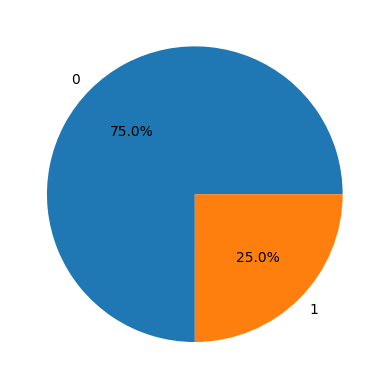

In [7]:
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, autopct = "%1.1f%%")
plt.show()

# Implementation

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class Embedding:

    def __init__(self, df, learning_rate, words, debug = False):

        self.EMBEDDING_SIZE = 5
        self.df = df
        self.lr = learning_rate
        self.debug = debug

        self.main_embeddings = np.random.normal(0,0.1,(len(words), self.EMBEDDING_SIZE))
        self.row_norms = np.sqrt((self.main_embeddings**2).sum(axis=1)).reshape(-1,1)
        self.main_embeddings = self.main_embeddings / self.row_norms

        self.context_embeddings = np.random.normal(0,0.1,(len(words), self.EMBEDDING_SIZE))
        self.row_norms = np.sqrt((self.context_embeddings**2).sum(axis=1)).reshape(-1,1)
        self.context_embeddings = self.context_embeddings / self.row_norms

        self.main_embeddings = pd.DataFrame(data=self.main_embeddings, index=words)
        self.context_embeddings = pd.DataFrame(data=self.context_embeddings, index=words)

    def train(self):

        for epoch in tqdm(range(1000)):
            main_emb_center = self.main_embeddings.loc[self.df.center_word].values
            context_emb_context = self.context_embeddings.loc[self.df.context_word].values
            diffs = context_emb_context - main_emb_center

            dot_prods = np.sum(main_emb_center * context_emb_context, axis=1)
            scores = sigmoid(dot_prods)
            errors = (self.df.label - scores).values.reshape(-1,1)

            updates = diffs*errors*self.lr
            updates_df = pd.DataFrame(data=updates)
            updates_df['center_word'] = self.df.center_word
            updates_df['context_word'] = self.df.context_word
            updates_df_center = updates_df.groupby('center_word').sum(numeric_only=True)
            updates_df_context = updates_df.groupby('context_word').sum(numeric_only=True)

            if self.debug and epoch % 200 == 0:
                self.plot_words(self.debug)

            self.main_embeddings += updates_df_center.loc[self.main_embeddings.index]
            self.context_embeddings -= updates_df_context.loc[self.context_embeddings.index]

            self.main_embeddings = self.normalize_data(self.main_embeddings)
            self.context_embeddings = self.normalize_data(self.context_embeddings)

        return self.main_embeddings, self.context_embeddings

    def normalize_data(self, data):
        row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
        return data.divide(row_norms, axis='index')

    def plot_words(self, debug):
        plt.figure(figsize=(8,4))

        plt.subplot(1,2,1)
        lim_main_first = self.main_embeddings.loc[[debug[0]]]
        lim_main_second = self.main_embeddings.loc[[debug[1]]]
        p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
        plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
        for idx,row in lim_main_first.iterrows():
            plt.text(row[0], row[1], str(idx))
        p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
        plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
        for idx,row in lim_main_second.iterrows():
            plt.text(row[0], row[1], str(idx))
        sim = 1 - cosine(self.main_embeddings.loc[debug[0]], self.main_embeddings.loc[debug[1]])
        plt.title('Sim = %s'%round(sim,4), fontsize=20)
        plt.axvline(0, color='k', linestyle='--', alpha=0.5)
        plt.axhline(0, color='k', linestyle='--', alpha=0.5)

        t = np.arange(0, 3.14*2+0.1, 0.1)
        plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')

        ###################################

        plt.subplot(1,2,2)
        lim_main = self.main_embeddings.loc[[debug[0]]]
        lim_context = self.context_embeddings.loc[[debug[1]]]
        p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
        plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
        for idx,row in lim_main.iterrows():
            plt.text(row[0], row[1], str(idx))
        p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
        plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
        for idx,row in lim_context.iterrows():
            plt.text(row[0], row[1], str(idx))
        sim = 1 - cosine(self.main_embeddings.loc[debug[0]], self.context_embeddings.loc[debug[1]])
        plt.title('Sim = %s'%round(sim,4), fontsize=20)
        plt.axvline(0, color='k', linestyle='--', alpha=0.5)
        plt.axhline(0, color='k', linestyle='--', alpha=0.5)

        plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')

        plt.show()

# Train

In [9]:
emb = Embedding(df, 0.01, words, ['cry', 'love'])

  0%|          | 0/1000 [00:00<?, ?it/s]

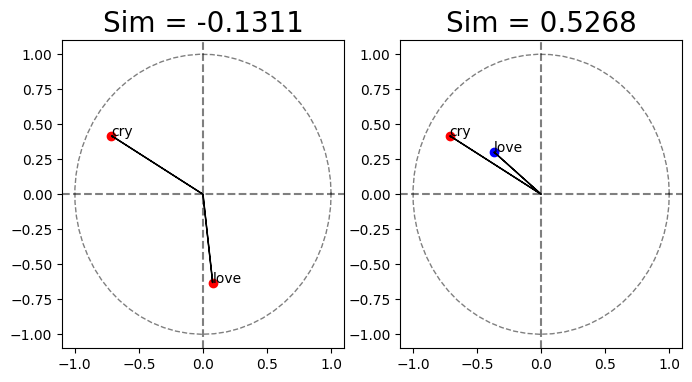

 20%|█▉        | 198/1000 [00:08<00:26, 30.30it/s]

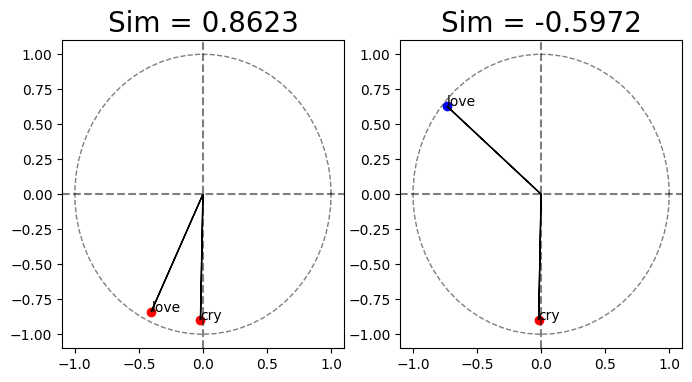

 40%|███▉      | 399/1000 [00:16<00:32, 18.68it/s]

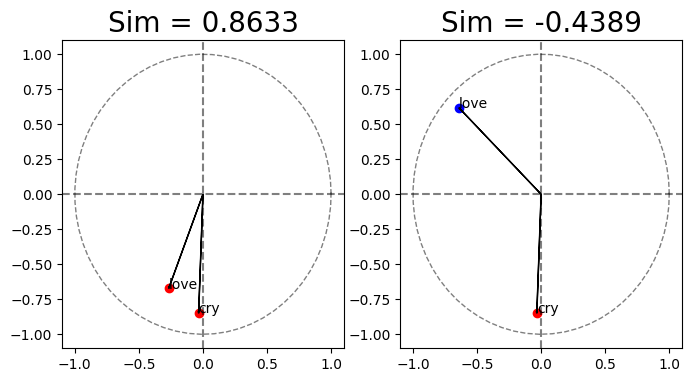

 60%|█████▉    | 597/1000 [00:24<00:13, 30.24it/s]

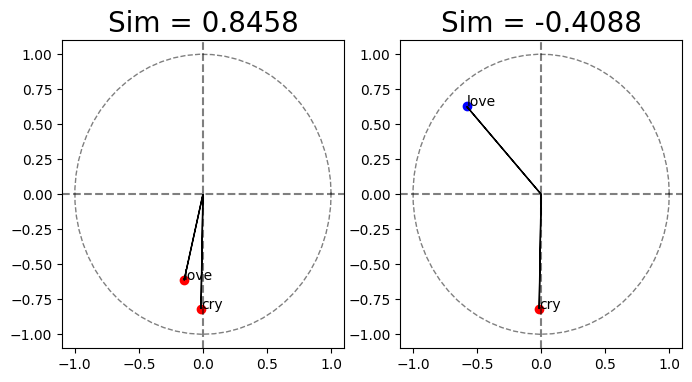

 80%|████████  | 800/1000 [00:33<00:06, 29.78it/s]

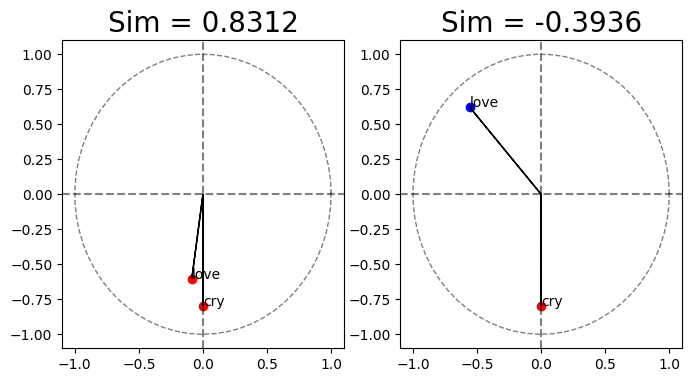

100%|██████████| 1000/1000 [00:41<00:00, 24.33it/s]


In [10]:
main_embeddings, context_embeddings = emb.train()

In [11]:
L = []
for w1 in tqdm(words):
    for w2 in words:
        if w1 != w2:
            sim = 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2])
            L.append((w1,w2,sim))
sorted([item for item in L if item[0] == 'love'], key=lambda t: -t[2])[:10]

100%|██████████| 788/788 [02:02<00:00,  6.42it/s]


[('love', 'wrong', 0.9835338637094453),
 ('love', 'copy', 0.9831203061045184),
 ('love', 'dress', 0.9819190565838845),
 ('love', 'buy', 0.9798829400633954),
 ('love', 'braindementiathis', 0.97759868632129),
 ('love', 'titsits', 0.9729882521068409),
 ('love', 'whats', 0.9712382421485992),
 ('love', 'realize', 0.9688672801380114),
 ('love', 'testes', 0.967257508053694),
 ('love', 'nowfrom', 0.9637342413975667)]

# Visualize with PCA

In [21]:
main_embeddings

,0,1,2,3,4
accomplish,-0.133538,-0.539527,-0.138004,0.495271,0.653253
across,0.263001,-0.204405,-0.863720,0.314926,0.209424
actually,0.082434,-0.739994,-0.448143,0.245816,-0.429367
afternoon,-0.224415,-0.545177,-0.393333,0.139459,0.691564
againthree,0.452910,-0.859983,0.213974,0.025872,0.094059
...,...,...,...,...,...
yellow,0.153506,-0.738572,-0.445990,-0.480137,0.038836
yellowwaxchloe,-0.060101,-0.655893,-0.063996,0.275096,0.697437
youre,0.409349,-0.474383,-0.463462,0.362089,0.511360
youthen,0.261204,-0.531056,-0.132318,0.721411,0.334381


In [30]:
pca_copy = main_embeddings.sample(20)

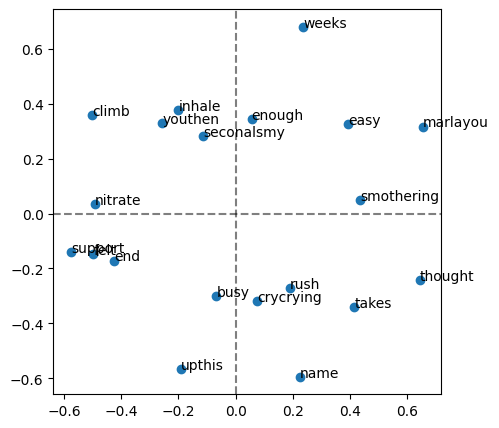

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transf_embeddings = pca.fit_transform(pca_copy.values)
words_used = pca_copy.index

plt.figure(figsize=(5,5))
plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])

for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))

plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.show()